In [1]:
import datetime
import os
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import Series

import seaborn as sns
sns.set()
matplotlib.style.use('seaborn-colorblind')

def DATASET_PATH(DATASET_NAME):
    full_filename = f"{DATASET_NAME}{SIZES[SELECTED_SIZE]}.parquet"
    return os.path.join(DATA_FOLDER, full_filename)

def PLOT(name, **kwdata):
    if not os.path.isdir(PLOT_FOLDER):
       os.makedirs(PLOT_FOLDER)
    plt.savefig(os.path.join(PLOT_FOLDER, f"{name}.pdf"))
    plt.show()
    plt.close()
    for key in kwdata:
        data = kwdata[key]
        str_resp = str(data)
        with open(os.path.join(PLOT_FOLDER, f"{name}_{key}.txt"), 'w') as f:
            f.write(str_resp)
            print(key, "\n", str_resp)
    
    

DATA_FOLDER = "data"
PLOT_FOLDER = "plots"
INPUT_FILE = "dataset"
SIZES = ['-0.01', '-0.1', '']
SELECTED_SIZE = 0

In [2]:
df = pd.read_parquet(DATASET_PATH(INPUT_FILE))

In [3]:
cov = lambda x: np.std(x, ddof=1) / np.mean(x) 

In [4]:
runtime_cov_df = df.groupby( ['provider'])['runtime'].apply(cov).dropna().reset_index(name='Runtime CV').set_index(['provider'])
resp_df = df.groupby( ['provider', 'driver_invocation']).size().reset_index(name='counts')

In [5]:
def boxplot(ax, df, ytitle):
    fig = ax.get_figure()
    gs = ax.get_subplotspec()
    ax.remove()
    ax = fig.add_subplot(gs)

    df.boxplot(subplots=False, ax=ax, showfliers=False)

    labels = []
    for tick in ax.get_xticklabels():
      provider = tick.get_text()[1:].split(',')[0]
      labels.append(f"{provider}")
    ax.set_xticklabels(labels)
    ax.set_ylabel(ytitle)
    plt.setp(ax.get_xticklabels(), rotation=0)

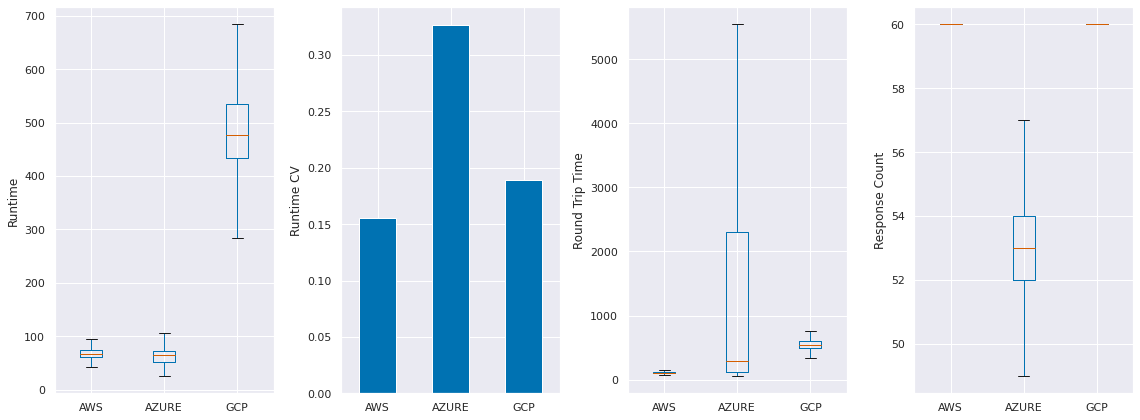

data 
            runtime                                                             \
             count        mean        std    min    25%    50%    75%     max   
provider                                                                        
AWS       173566.0   69.073206  10.714942   31.0   62.0   67.0   75.0   567.0   
AZURE     151962.0   62.751780  20.487580   26.0   51.0   64.0   73.0  4066.0   
GCP       174008.0  481.566261  91.113365  130.0  434.0  476.0  534.0  4290.0   

         roundTripTime                                                    \
                 count        mean          std     min     25%      50%   
provider                                                                   
AWS           173566.0  124.796232   551.590142   68.77   99.82  108.860   
AZURE         151962.0  972.913213  1200.538127   60.40  121.14  282.545   
GCP           174008.0  566.612940   195.953561  210.82  496.00  536.680   

                             
              75%  

In [6]:

# Plot Coefficient Of Variation Per Cloud Provider:
fig, axes = plt.subplots(figsize=(16,6), ncols=4, nrows=1, frameon=False, sharex=True)

runtime_bx_ax = axes[0]
runtime_cov_ax = axes[1]
roundtrip_bx_ax = axes[2]
respcount_bx_ax = axes[3]

# Runtime COV
runtime_cov_df.plot(kind='bar', ax=runtime_cov_ax)
runtime_cov_ax.set_xlabel('')
runtime_cov_ax.set_ylabel('Runtime CV')
runtime_cov_ax.get_legend().remove()
plt.setp(runtime_cov_ax.get_xticklabels(), rotation=0)

# Boxplot Runtime
## Setup Boxplot Axes
df_boxplot = df[['provider', 'runtime']].sort_values(by=['provider']).groupby(['provider'], observed=True)
boxplot(runtime_bx_ax, df_boxplot, 'Runtime')

df_boxplot = df[['provider', 'roundTripTime']].sort_values(by=['provider']).groupby(['provider'], observed=True)
boxplot(roundtrip_bx_ax, df_boxplot, 'Round Trip Time')

df_boxplot = resp_df[['provider', 'counts']].sort_values(by=['provider']).groupby(['provider'], observed=True)
boxplot(respcount_bx_ax, df_boxplot, 'Response Count')

fig.tight_layout()

data = df[['provider', 'runtime', 'roundTripTime']].groupby(['provider'], observed=True).describe()
PLOT('provider_mean_cov', data=data, respdata=resp_df.describe())